# CMIP6 PH sandbox

Date: 6 September, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dask.distributed import Client, LocalCluster
import dask
import datetime
import zarr

import gc
import sys
import subprocess
from tabulate import tabulate
import os
import glob
#import streamjoy


#### start a local Dask client (adjust this for your cluster)

In [2]:
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

cluster = LocalCluster( # Number of workers
    threads_per_worker=1#,
    #memory_limit='8GB' # Memory limit per each worker
)
client = Client(cluster)

# load example CMIP datasets

In [3]:
paths_dict = {'CMCC-ESM2':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp126/r1i1p1f1/Omon/ph/gn/v20210126/*',
              'MPI-ESM1-2-HR':'/g/data/oi10/replicas/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp126/r1i1p1f1/Omon/ph/gn/v20190710/*'}

In [4]:
datasets = {}
for model, path in paths_dict.items():
    datasets[model] = xr.open_mfdataset(path,parallel=True)

# Now you can access the datasets using the model names as keys
# For example:
cmcc_esm2_dataset = datasets['CMCC-ESM2']
mpi_esm1_2_hr_dataset = datasets['MPI-ESM1-2-HR']

In [5]:
cmcc_esm2_dataset

<xarray.Dataset> Size: 29GB
Dimensions:             (time: 1032, bnds: 2, lev: 50, i: 292, j: 362,
                         vertices: 4)
Coordinates:
  * time                (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 ...
  * lev                 (lev) float64 400B 0.5126 1.621 ... 5.498e+03 5.904e+03
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 286 287 288 289 290 291
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 356 357 358 359 360 361
    latitude            (i, j) float64 846kB dask.array<chunksize=(292, 362), meta=np.ndarray>
    longitude           (i, j) float64 846kB dask.array<chunksize=(292, 362), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 17kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 826kB dask.array<chunksize=(240, 50, 2), meta=np.ndarray>
    vertices_latitude   (time, i, j, vertices) float64 3GB dask.array<chunksize=(240, 292, 362, 4), meta=np.ndarray>
    vertices_longitude  (time, i, j, vertices) float64 3GB dask.array<chunksize=(240, 292, 362, 4), meta=np.ndarray>
    ph                  (time, lev, i, j) float32 22GB dask.array<chunksize=(1, 25, 146, 181), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            ph
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/13d78629-227f-45b1-ad45-2512555b6771

In [6]:
mpi_esm1_2_hr_dataset

<xarray.Dataset> Size: 75GB
Dimensions:             (time: 1032, bnds: 2, lev: 40, j: 404, i: 802,
                         vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 210...
  * lev                 (lev) float64 320B 6.0 17.0 27.0 ... 5.17e+03 5.72e+03
  * j                   (j) int32 2kB 0 1 2 3 4 5 6 ... 398 399 400 401 402 403
  * i                   (i) int32 3kB 0 1 2 3 4 5 6 ... 796 797 798 799 800 801
    latitude            (j, i) float64 3MB dask.array<chunksize=(404, 802), meta=np.ndarray>
    longitude           (j, i) float64 3MB dask.array<chunksize=(404, 802), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 17kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 660kB dask.array<chunksize=(60, 40, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 11GB dask.array<chunksize=(60, 202, 401, 2), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float64 11GB dask.array<chunksize=(60, 202, 401, 2), meta=np.ndarray>
    ph                  (time, lev, j, i) float32 54GB dask.array<chunksize=(1, 14, 135, 268), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ph
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by DKRZ is licensed und...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/f460ef78-b23d-4130-87a1-2402e0bbb6bd

Text(0.5, 1.0, 'Comparison of level coordinates between models')

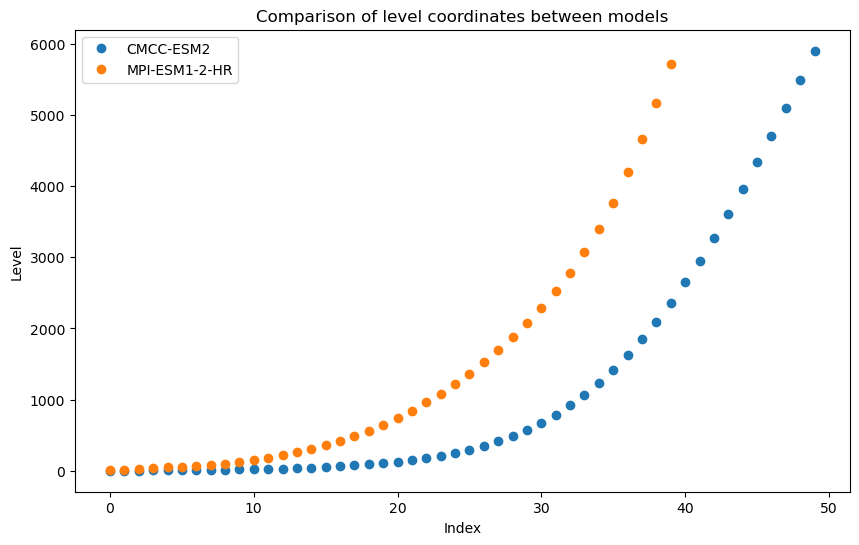

In [7]:
cmcc_esm2_levels = cmcc_esm2_dataset.lev
mpi_esm1_2_hr_levels = mpi_esm1_2_hr_dataset.lev


plt.figure(figsize=(10, 6))
plt.plot(cmcc_esm2_levels, 'o', label='CMCC-ESM2')
plt.plot(mpi_esm1_2_hr_levels, 'o', label='MPI-ESM1-2-HR')
plt.xlabel('Index')
plt.ylabel('Level')
plt.legend()
plt.title('Comparison of level coordinates between models')

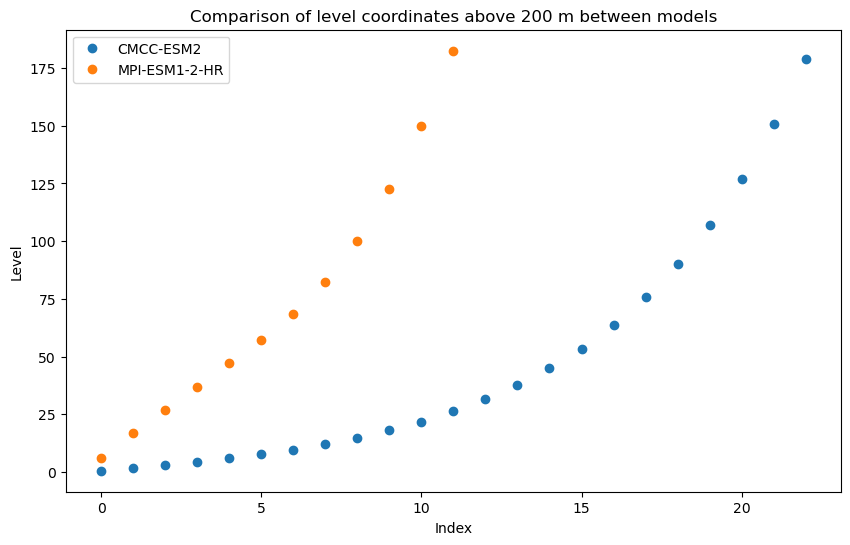

Number of points above 200 m for CMCC-ESM2: 23
Number of points above 200 m for MPI-ESM1-2-HR: 12


In [8]:
# Filter the data points above 200 m for each model
cmcc_esm2_above_200m = cmcc_esm2_levels[cmcc_esm2_levels <= 200]
mpi_esm1_2_hr_above_200m = mpi_esm1_2_hr_levels[mpi_esm1_2_hr_levels <= 200]

# Plot the filtered data points
plt.figure(figsize=(10, 6))
plt.plot(cmcc_esm2_above_200m, 'o', label='CMCC-ESM2')
plt.plot(mpi_esm1_2_hr_above_200m, 'o', label='MPI-ESM1-2-HR')
plt.xlabel('Index')
plt.ylabel('Level')
plt.legend()
plt.title('Comparison of level coordinates above 200 m between models')
plt.show()

# Count the number of points above 200 m for each model
cmcc_esm2_count = len(cmcc_esm2_above_200m)
mpi_esm1_2_hr_count = len(mpi_esm1_2_hr_above_200m)

# Print the number of points for each model
print(f"Number of points above 200 m for CMCC-ESM2: {cmcc_esm2_count}")
print(f"Number of points above 200 m for MPI-ESM1-2-HR: {mpi_esm1_2_hr_count}")

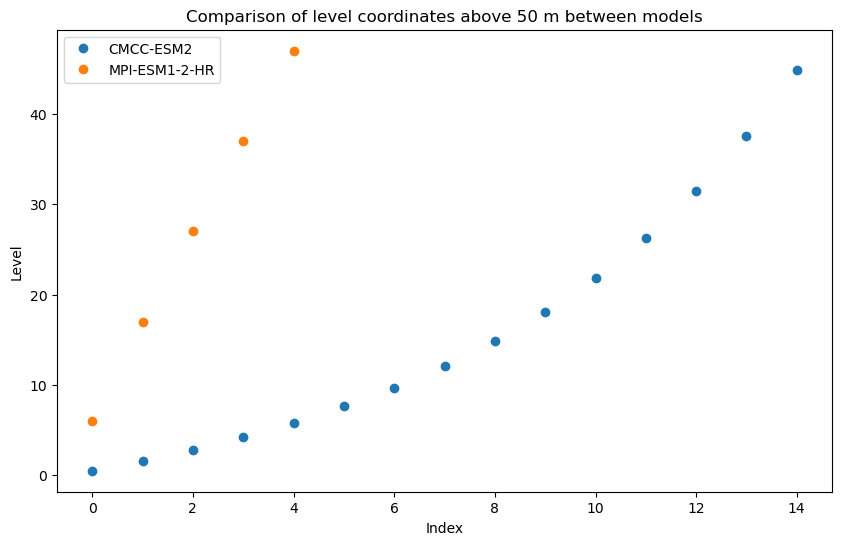

Number of points above 50 m for CMCC-ESM2: 15
Number of points above 50 m for MPI-ESM1-2-HR: 5


In [9]:
# Filter the data points above 50 m for each model
cmcc_esm2_above_50m = cmcc_esm2_levels[cmcc_esm2_levels <= 50]
mpi_esm1_2_hr_above_50m = mpi_esm1_2_hr_levels[mpi_esm1_2_hr_levels <= 50]
# Plot the filtered data points
plt.figure(figsize=(10, 6))
plt.plot(cmcc_esm2_above_50m, 'o', label='CMCC-ESM2')
plt.plot(mpi_esm1_2_hr_above_50m, 'o', label='MPI-ESM1-2-HR')
plt.xlabel('Index')
plt.ylabel('Level')
plt.legend()
plt.title('Comparison of level coordinates above 50 m between models')
plt.show()

# Count the number of points above 50 m for each model
cmcc_esm2_count = len(cmcc_esm2_above_50m)
mpi_esm1_2_hr_count = len(mpi_esm1_2_hr_above_50m)

# Print the number of points for each model
print(f"Number of points above 50 m for CMCC-ESM2: {cmcc_esm2_count}")
print(f"Number of points above 50 m for MPI-ESM1-2-HR: {mpi_esm1_2_hr_count}")

## OPTION: take the approach of not throwing away the better resolved profiles of `CMCC-ESM2`

## simple approaches - linear interpolation
### see: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html
### see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d

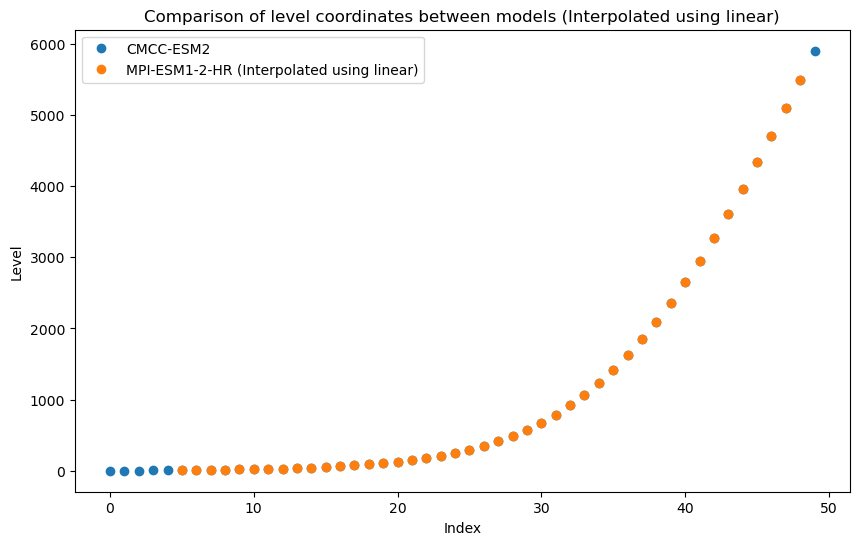

Number of points above 200 m for MPI-ESM1-2-HR (Interpolated using linear): 26
Number of points above 50 m for MPI-ESM1-2-HR (Interpolated using linear): 34


In [10]:
# Interpolate mpi_esm1_2_hr levels onto cmcc_esm2 levels
method_str = 'linear'
mpi_esm1_2_hr_levels_interp = mpi_esm1_2_hr_levels.interp(lev=cmcc_esm2_levels,assume_sorted=True,method=method_str)

# Plot the interpolated data points
plt.figure(figsize=(10, 6))
plt.plot(cmcc_esm2_levels, 'o', label='CMCC-ESM2')
plt.plot(mpi_esm1_2_hr_levels_interp, 'o', label=f'MPI-ESM1-2-HR (Interpolated using {method_str})')
plt.xlabel('Index')
plt.ylabel('Level')
plt.legend()
plt.title(f'Comparison of level coordinates between models (Interpolated using {method_str})')
plt.show()

# Count the number of points above 200 m for each model after interpolation
mpi_esm1_2_hr_above_200m_interp = mpi_esm1_2_hr_levels_interp[mpi_esm1_2_hr_levels_interp > 200]
mpi_esm1_2_hr_count_interp = len(mpi_esm1_2_hr_above_200m_interp)
print(f"Number of points above 200 m for MPI-ESM1-2-HR (Interpolated using {method_str}): {mpi_esm1_2_hr_count_interp}")

# Count the number of points above 50 m for each model after interpolation
mpi_esm1_2_hr_above_50m_interp = mpi_esm1_2_hr_levels_interp[mpi_esm1_2_hr_levels_interp > 50]
mpi_esm1_2_hr_count_interp = len(mpi_esm1_2_hr_above_50m_interp)
print(f"Number of points above 50 m for MPI-ESM1-2-HR (Interpolated using {method_str}): {mpi_esm1_2_hr_count_interp}")

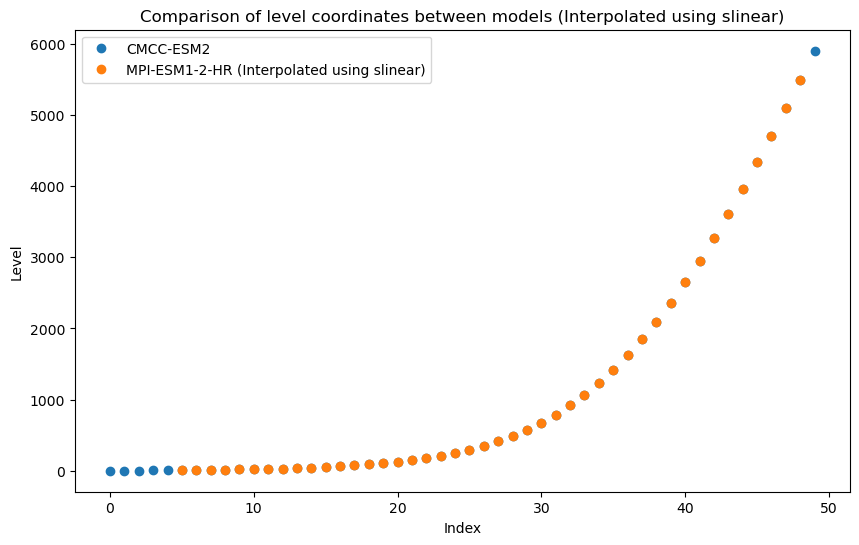

Number of points above 200 m for MPI-ESM1-2-HR (Interpolated using slinear): 26
Number of points above 50 m for MPI-ESM1-2-HR (Interpolated using slinear): 34


In [11]:
# Interpolate mpi_esm1_2_hr levels onto cmcc_esm2 levels
method_str = 'slinear'
mpi_esm1_2_hr_levels_interp = mpi_esm1_2_hr_levels.interp(lev=cmcc_esm2_levels,assume_sorted=True,method=method_str)

# Plot the interpolated data points
plt.figure(figsize=(10, 6))
plt.plot(cmcc_esm2_levels, 'o', label='CMCC-ESM2')
plt.plot(mpi_esm1_2_hr_levels_interp, 'o', label=f'MPI-ESM1-2-HR (Interpolated using {method_str})')
plt.xlabel('Index')
plt.ylabel('Level')
plt.legend()
plt.title(f'Comparison of level coordinates between models (Interpolated using {method_str})')
plt.show()

# Count the number of points above 200 m for each model after interpolation
mpi_esm1_2_hr_above_200m_interp = mpi_esm1_2_hr_levels_interp[mpi_esm1_2_hr_levels_interp > 200]
mpi_esm1_2_hr_count_interp = len(mpi_esm1_2_hr_above_200m_interp)
print(f"Number of points above 200 m for MPI-ESM1-2-HR (Interpolated using {method_str}): {mpi_esm1_2_hr_count_interp}")

# Count the number of points above 50 m for each model after interpolation
mpi_esm1_2_hr_above_50m_interp = mpi_esm1_2_hr_levels_interp[mpi_esm1_2_hr_levels_interp > 50]
mpi_esm1_2_hr_count_interp = len(mpi_esm1_2_hr_above_50m_interp)
print(f"Number of points above 50 m for MPI-ESM1-2-HR (Interpolated using {method_str}): {mpi_esm1_2_hr_count_interp}")

# see: https://docs.xarray.dev/en/stable/user-guide/interpolation.html

In [12]:
# Interpolate mpi_esm1_2_hr data onto cmcc_esm2 levels
method_str = 'linear'
mpi_esm1_2_hr_interp_linear_dataset = mpi_esm1_2_hr_dataset.interp(lev=cmcc_esm2_levels,assume_sorted=True,method=method_str)

In [13]:
# Interpolate mpi_esm1_2_hr data onto cmcc_esm2 levels
method_str = 'slinear'
mpi_esm1_2_hr_interp_slinear_dataset = mpi_esm1_2_hr_dataset.interp(lev=cmcc_esm2_levels,assume_sorted=True,method=method_str)

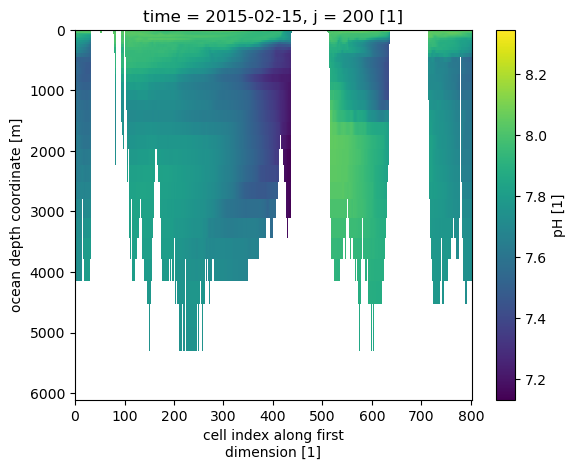

In [14]:
mpi_esm1_2_hr_interp_linear_dataset.ph.sel({'j':200,'time':'2015-02-16'},method='nearest').plot()
# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

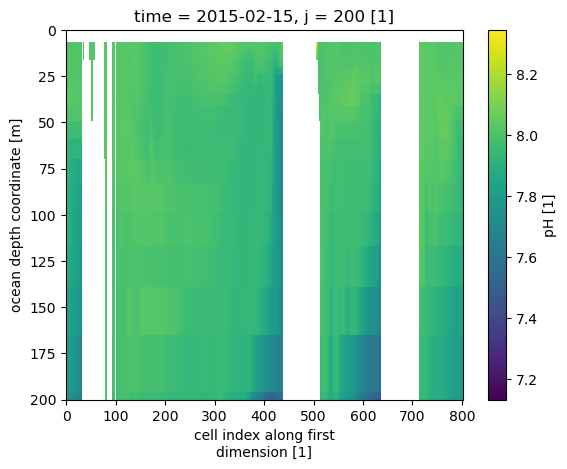

In [15]:
mpi_esm1_2_hr_interp_linear_dataset.ph.sel({'j':200,'time':'2015-02-16'},method='nearest').plot()
# Invert the y-axis
plt.gca().invert_yaxis()
plt.gca().set_ylim(bottom=200, top=0)
plt.show()


In [16]:
diff = mpi_esm1_2_hr_interp_linear_dataset - mpi_esm1_2_hr_interp_slinear_dataset

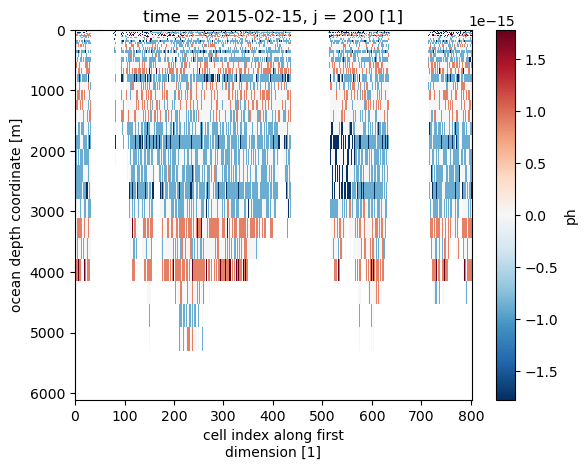

In [17]:
diff.ph.sel({'j':200,'time':'2015-02-16'},method='nearest').plot()
# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

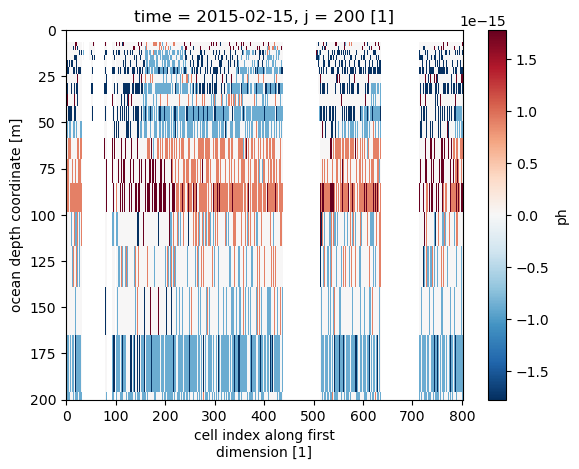

In [18]:
diff.ph.sel({'j':200,'time':'2015-02-16'},method='nearest').plot()
# Invert the y-axis
plt.gca().invert_yaxis()
plt.gca().set_ylim(bottom=200, top=0)
plt.show()

# rlgregory - code yeilds `NaN`

In [ ]:
import xesmf as xe

#lat/lons required for this work (Federated States of Micronesia)
#may need to split these into 4 states - wait for confirmation of lat lons for each state - this is whole of FSM
minlon=135.0
maxlon=170.0
minlat=-1.0
maxlat=14.0

#OceanSODA grid to regrid all models and CMCC model used to interpolate onto for ocean level data
#new grid for regridding to OceanSODA
newgrid = xr.open_mfdataset('/g/data/dk7/rg9861/OA/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')
#new lev for interpolating to CMCC model levels
cmcclev = xr.open_mfdataset(f'/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp126/r1i1p1f1/Omon/ph/gn/v20210126/ph_Omon_CMCC-ESM2_ssp126_r1i1p1f1_gn_201501-203412.nc',use_cftime=True)
newlev = cmcclev.lev

#open a GCM dataset
ph = xr.open_mfdataset(f'/g/data/oi10/replicas/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp126/r1i1p1f1/Omon/ph/gr/v20180701/ph_Omon_GFDL-ESM4_ssp126_r1i1p1f1_gr_*.nc',use_cftime=True,decode_cf=True).sel(time=slice("2020-01-01","2099-12-31"))
ph

#run the regridder code for OceanSODA
regridder = xe.Regridder(ph, newgrid, "bilinear",periodic=True,ignore_degenerate=True)
temp = regridder(ph,keep_attrs=True,skipna=True,na_thres=.5)

#cut to desired lat/lons
mylon = temp.lon[:]
mylat = temp.lat[:]
temp = temp.assign_coords(lat=list(mylat.values)).assign_coords(lon=list(mylon.values))
temp_sub = temp.sel(lon=slice(minlon,maxlon),lat=slice(minlat,maxlat))

#show ph values for all times, but just first lat/lon grid cell
temp_sub['ph'][0,0,0,:].values

#interpolating to CMCC ocean levels
temp_sub_lev = temp_sub.interp(lev=newlev,assume_sorted=True,method='linear')

#save only first level
temp_sub_lev1 = temp_sub_lev.isel(lev=0)

#show ph values for all times, but just first lat/lon grid cell
temp_sub_lev1['ph'][:,0,0].values

In [3]:
import xesmf as xe

In [4]:
#lat/lons required for this work (Federated States of Micronesia)
#may need to split these into 4 states - wait for confirmation of lat lons for each state - this is whole of FSM
minlon=135.0
maxlon=170.0
minlat=-1.0
maxlat=14.0

In [5]:
#OceanSODA grid to regrid all models and CMCC model used to interpolate onto for ocean level data
#new grid for regridding to OceanSODA
newgrid = xr.open_mfdataset('/g/data/dk7/rg9861/OA/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')
#new lev for interpolating to CMCC model levels
cmcclev = xr.open_mfdataset(f'/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp126/r1i1p1f1/Omon/ph/gn/v20210126/ph_Omon_CMCC-ESM2_ssp126_r1i1p1f1_gn_201501-203412.nc',use_cftime=True)
newlev = cmcclev.lev

In [6]:
newgrid

<xarray.Dataset> Size: 3GB
Dimensions:          (time: 492, lat: 180, lon: 360, region: 4)
Coordinates:
  * time             (time) datetime64[ns] 4kB 1982-01-15 ... 2022-12-15
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * region           (region) <U7 112B 'global' 'north' 'tropics' 'south'
Data variables: (12/28)
    talk             (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    dic              (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    spco2            (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    sfco2            (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    ph_total         (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    ph_free          (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    ...               ...
    area             (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    fgco2_reg        (region, time) float32 8kB dask.array<chunksize=(4, 492), meta=np.ndarray>
    area_reg         (region) float32 16B dask.array<chunksize=(4,), meta=np.ndarray>
    ice              (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    kw               (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
    sol              (time, lat, lon) float32 128MB dask.array<chunksize=(246, 90, 180), meta=np.ndarray>
Attributes:
    contact:      gregorl@ethz.ch
    author:       Luke Gregor
    institution:  ETH Zuerich
    version:      v2023.GCB
    date:         2023-06-26
    description:  talk and pco2 (more accurately fco2) are estimated with two...
    changelog:    v2021d: Extended from 1982-2020; Now using: OISSTv2.1 for S...
    reference:    Gregor, L. and Gruber, N.: OceanSODA-ETHZ: A global gridded...
    source:       https://doi.org/10.25921/m5wx-ja34
    product:      OSETHZ-v2023.GCB

In [7]:
newlev

<xarray.DataArray 'lev' (lev: 50)> Size: 400B
array([5.126340e-01, 1.621015e+00, 2.858431e+00, 4.250513e+00, 5.827960e+00,
       7.627532e+00, 9.693230e+00, 1.207770e+01, 1.484391e+01, 1.806713e+01,
       2.183723e+01, 2.626152e+01, 3.146791e+01, 3.760874e+01, 4.486517e+01,
       5.345229e+01, 6.362492e+01, 7.568428e+01, 8.998535e+01, 1.069451e+02,
       1.270512e+02, 1.508713e+02, 1.790624e+02, 2.123794e+02, 2.516826e+02,
       2.979431e+02, 3.522440e+02, 4.157769e+02, 4.898312e+02, 5.757748e+02,
       6.750254e+02, 7.890108e+02, 9.191196e+02, 1.066644e+03, 1.232717e+03,
       1.418255e+03, 1.623902e+03, 1.849991e+03, 2.096521e+03, 2.363159e+03,
       2.649263e+03, 2.953915e+03, 3.275983e+03, 3.614175e+03, 3.967101e+03,
       4.333334e+03, 4.711457e+03, 5.100101e+03, 5.497977e+03, 5.903893e+03])
Coordinates:
  * lev      (lev) float64 400B 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
Attributes:
    bounds:         lev_bnds
    units:          m
    axis:           Z
    positive:       down
    long_name:      ocean depth coordinate
    standard_name:  depth

In [8]:
#open a GCM dataset
ph = xr.open_mfdataset(f'/g/data/oi10/replicas/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp126/r1i1p1f1/Omon/ph/gr/v20180701/ph_Omon_GFDL-ESM4_ssp126_r1i1p1f1_gr_*.nc',use_cftime=True,decode_cf=True).sel(time=slice("2020-01-01","2099-12-31"))
ph

<xarray.Dataset> Size: 9GB
Dimensions:    (time: 960, lat: 180, bnds: 2, lon: 360, lev: 35)
Coordinates:
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 8kB 2020-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lev        (lev) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 3MB dask.array<chunksize=(180, 180, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 6MB dask.array<chunksize=(180, 360, 2), meta=np.ndarray>
    ph         (time, lev, lat, lon) float32 9GB dask.array<chunksize=(1, 18, 90, 180), meta=np.ndarray>
    time_bnds  (time, bnds) object 15kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 538kB dask.array<chunksize=(180, 35, 2), meta=np.ndarray>
Attributes: (12/46)
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    history:                File was processed by fremetar (GFDL analog of CM...
    external_variables:     areacello volcello
    table_id:               Omon
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    sub_experiment_id:      none
    tracking_id:            hdl:21.14100/aab8e08d-59fd-492d-a6a5-fdda28bec3a3
    variable_id:            ph
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

In [9]:
#run the regridder code for OceanSODA
regridder = xe.Regridder(ph, newgrid, "bilinear",periodic=True,ignore_degenerate=True)
temp = regridder(ph,keep_attrs=True,skipna=True,na_thres=.5)

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0611
--------------------------------------------------------------------------


In [11]:
newgrid.lat

<xarray.DataArray 'lat' (lat: 180)> Size: 1kB
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5

In [12]:
ph.lat

<xarray.DataArray 'lat' (lat: 180)> Size: 1kB
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5])
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    bounds:         lat_bnds
    standard_name:  latitude
    cell_methods:   time: point

In [15]:
#cut to desired lat/lons
mylon = temp.lon[:]
mylat = temp.lat[:]
temp = temp.assign_coords(lat=list(mylat.values)).assign_coords(lon=list(mylon.values))
temp_sub = temp.sel(lon=slice(minlon,maxlon),lat=slice(minlat,maxlat))

In [16]:
temp_sub

<xarray.Dataset> Size: 141MB
Dimensions:  (time: 960, lev: 35, lat: 15, lon: 35)
Coordinates:
  * time     (time) object 8kB 2020-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lev      (lev) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
  * lat      (lat) float64 120B -0.5 0.5 1.5 2.5 3.5 ... 9.5 10.5 11.5 12.5 13.5
  * lon      (lon) float64 280B 135.5 136.5 137.5 138.5 ... 167.5 168.5 169.5
Data variables:
    ph       (time, lev, lat, lon) float64 141MB dask.array<chunksize=(1, 18, 1, 35), meta=np.ndarray>
Attributes: (12/47)
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    history:                File was processed by fremetar (GFDL analog of CM...
    external_variables:     areacello volcello
    table_id:               Omon
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/aab8e08d-59fd-492d-a6a5-fdda28bec3a3
    variable_id:            ph
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    regrid_method:          bilinear

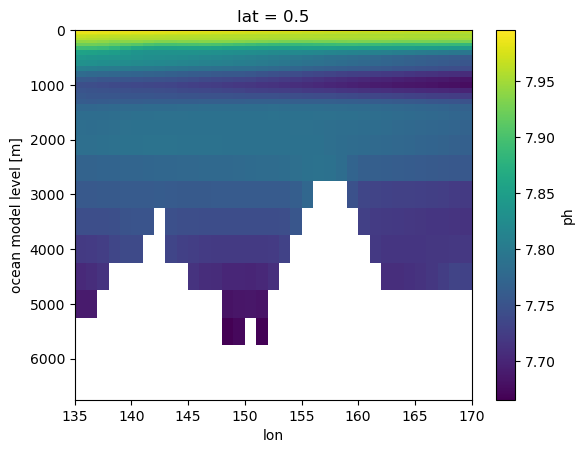

In [19]:
temp_sub.ph.mean('time').sel({'lat':0},method='nearest').plot()
# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [20]:
#interpolating to CMCC ocean levels
temp_sub_lev = temp_sub.interp(lev=newlev,assume_sorted=True,method='linear')

In [21]:
temp_sub_lev

<xarray.Dataset> Size: 202MB
Dimensions:  (time: 960, lev: 50, lat: 15, lon: 35)
Coordinates:
  * time     (time) object 8kB 2020-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat      (lat) float64 120B -0.5 0.5 1.5 2.5 3.5 ... 9.5 10.5 11.5 12.5 13.5
  * lon      (lon) float64 280B 135.5 136.5 137.5 138.5 ... 167.5 168.5 169.5
  * lev      (lev) float64 400B 0.5126 1.621 2.858 ... 5.498e+03 5.904e+03
Data variables:
    ph       (time, lev, lat, lon) float64 202MB dask.array<chunksize=(1, 50, 1, 35), meta=np.ndarray>
Attributes: (12/47)
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    history:                File was processed by fremetar (GFDL analog of CM...
    external_variables:     areacello volcello
    table_id:               Omon
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    tracking_id:            hdl:21.14100/aab8e08d-59fd-492d-a6a5-fdda28bec3a3
    variable_id:            ph
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    regrid_method:          bilinear

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 9.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


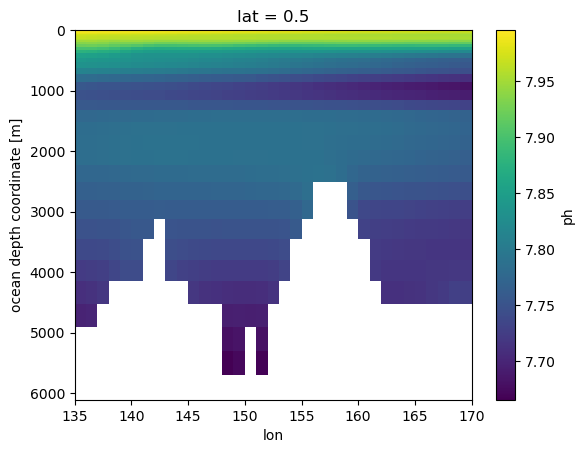

In [22]:
temp_sub_lev.ph.mean('time').sel({'lat':0},method='nearest').plot()
# Invert the y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [27]:
#save only first level
temp_sub_lev1 = temp_sub_lev.isel(lev=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 11.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


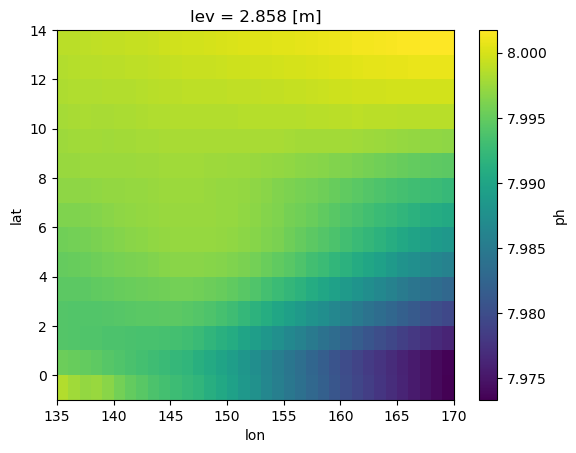

In [29]:
temp_sub_lev.ph.mean('time').sel({'lev':3},method='nearest').plot()

# $The$ $End$

In [ ]:
client.shutdown()

In [13]:
ph.lat == newgrid.lat

<xarray.DataArray 'lat' (lat: 162)> Size: 162B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5

In [14]:
ph.lon == newgrid.lon

<xarray.DataArray 'lon' (lon: 163)> Size: 163B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])
Coordinates:
  * lon      (lon) float64 1kB 0.5 2.5 3.5 4.5 5.5 ... 176.5 177.5 178.5 179.5

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')